1)

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



In [91]:
def IoU(box1, box2):
    box1_area = (box1[2]) * (box1[3])
    box2_area = (box2[2]) * (box2[3])
    
    max1 = max(box1[0], box2[0])
    max2 = max(box1[1], box2[1])
    min1 = min(box1[0] + box1[2], box2[0] + box2[2])
    min2 = min(box1[1] + box1[3], box2[1] + box2[3])

    intersection = (min1 - max1) * (min2 - max2)
    return intersection / float(box1_area + box2_area - intersection)

In [110]:
def plot_iou(iou_list):
  # plot IoU over time 
  num_frame = len(iou_list)
  plt.plot(range(num_frame), IoU_list)
  plt.xlabel('frame')
  plt.ylabel('IoU value')
  plt.show()

In [122]:
def plot_lowest_highest_frame(lowest_frame, lowest_window,
highest_frame, highest_window, window_always):
  x, y, w, h = highest_window
  cv2.rectangle(highest_frame, (x, y), (x + w, y + h), (255, 0, 0), 3)
  x, y, w, h = window_always
  cv2.rectangle(highest_frame, (x, y), (x + w, y + h), (0, 255, 0), 3)

  x, y, w, h = lowest_window
  cv2.rectangle(lowest_frame, (x, y), (x + w, y + h), (255, 0, 0), 3)
  x, y, w, h = window_always
  cv2.rectangle(lowest_frame, (x, y), (x + w, y + h), (0, 255, 0), 3)

  fig, axes = plt.subplots(2, figsize=(12, 10))

  axes[0].set_title('Highest IoU frame')
  axes[0].imshow(highest_frame)

  axes[1].set_title('Lowest IoU frame')
  axes[1].imshow(lowest_frame)

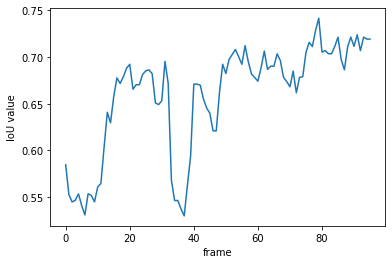

track window is red, detected window is green


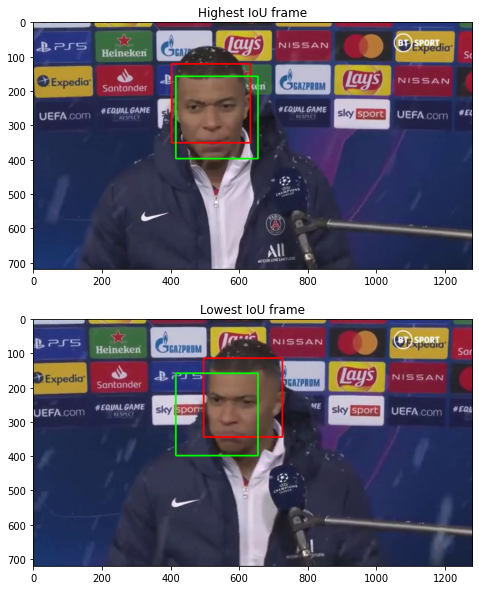

In [140]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Colab_Notebooks/KylianMbappe.mp4')
ret, frame = cap.read()
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_boxes = face_detector.detectMultiScale(frame)

if len(face_boxes) == 0:
  print('No Face Detected!')
  assert(False)

window_tracked = face_boxes[0]
x, y, w, h = tuple(window_tracked) 
roi = frame[y:y + h, x:x + w]

hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )


current_window = (x, y, w, h)
store_frames = []
IoU_list = []
lowest_frame, lowest_window, lowest_IoU = None, None, 1
highest_frame, highest_window, highest_IoU = None, None, 0
while True:
    ret, frame = cap.read() 
    if ret == True:   
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        ret, window_tracked = cv2.meanShift(dst, window_tracked, term_crit)
        face_boxes = face_detector.detectMultiScale(frame)

        max_iou = 0
        window_always = None
        if len(face_boxes) != 0: 
          for corners in face_boxes:
              next_iou = IoU(corners, current_window)
              if next_iou > max_iou:
                  max_iou = next_iou
                  window_always = corners
          iou = IoU(window_always, window_tracked)
        else:
          iou = 0
        IoU_list.append(iou)
        current_window = window_always
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if iou > highest_IoU:
          highest_IoU = iou
          highest_window = window_tracked
          highest_frame = frame
        elif iou < lowest_IoU:
          lowest_IoU = iou
          lowest_window = window_tracked
          lowest_frame = frame
        if iou < 0.6:
          x, y, w, h = window_tracked
          frame_cpy = frame.copy()
          cv2.rectangle(frame_cpy, (x, y), (x + w, y + h), (255, 0, 0), 3)
          x, y, w, h = window_always
          cv2.rectangle(frame_cpy, (x, y), (x + w, y + h), (0, 255, 0), 3)
          store_frames.append(frame_cpy)
        if cv2.waitKey(33) & 0xFF == 27: 
            break
    else:
        break

plot_iou(IoU_list)
plot_lowest_highest_frame(lowest_frame, lowest_window,
highest_frame, highest_window, window_always)
print("track window is red, detected window is green")


19


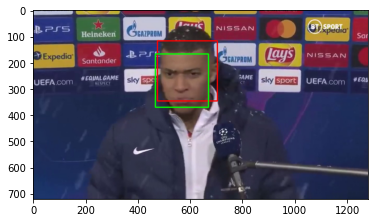

In [141]:
print(len(store_frames))
for frame in store_frames:
  plt.imshow(frame)

 didn't find frame with iou under 10%, so I choose 60%

In [137]:
greater_than_50 = 0
greater_than_60 = 0
for element in IoU_list:
  if element > 0.5:
    greater_than_50 += 1
  if element > 0.6:
    greater_than_60 += 1
print("The percentage of frames with iou > 50% is {}".format(greater_than_50 / len(IoU_list)))
print("The percentage of frames with iou > 60% is {}".format(greater_than_60 / len(IoU_list)))

The percentage of frames with iou > 50% is 1.0
The percentage of frames with iou > 60% is 0.9270833333333334


2)

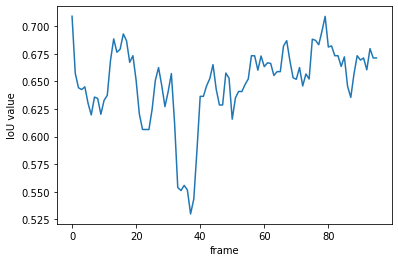

track window is red, detected window is green


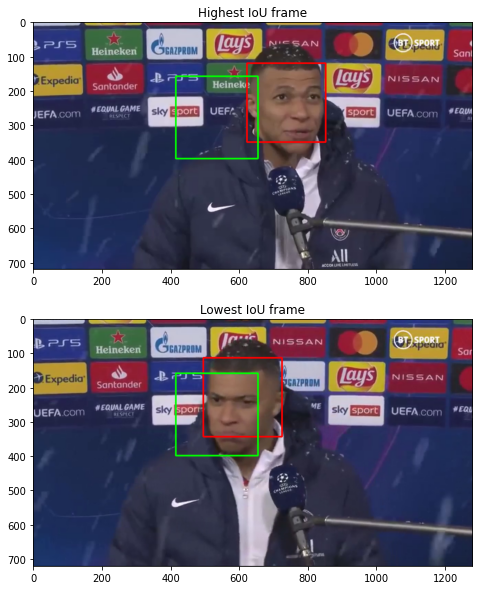

In [133]:
cap = cv2.VideoCapture('/content/drive/MyDrive/Colab_Notebooks/KylianMbappe.mp4')
ret, frame = cap.read()
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_boxes = face_detector.detectMultiScale(frame)

if len(face_boxes) == 0:
  print('No Face Detected!')
  assert(False)

window_tracked = face_boxes[0]
x, y, w, h = tuple(window_tracked) 
roi = frame[y:y + h, x:x + w]

roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
roi = cv2.GaussianBlur(roi, (5, 5), 7)
I_x = cv2.Sobel(roi, cv2.CV_64F, 1, 0, ksize=5)
I_y = cv2.Sobel(roi, cv2.CV_64F, 0, 1, ksize=5)
mag, ang = cv2.cartToPolar(I_x, I_y, angleInDegrees=True) 
cv2.cartToPolar(I_x, I_y, mag, ang, angleInDegrees=True)

mask = cv2.inRange(mag, np.max(mag) * .1, np.inf)

gradient_hist = cv2.calcHist([np.uint16(ang)], [0], mask, [24], [0, 360])
cv2.normalize(gradient_hist, gradient_hist, 0, 255, cv2.NORM_MINMAX)
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )


current_window = (x, y, w, h)
IoU_list = []
lowest_frame, lowest_window, lowest_IoU = None, None, 1
highest_frame, highest_window, highest_IoU = None, None, 0
while True:
    ret, frame = cap.read() 
    if ret == True:   
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0], gradient_hist,[0, 360], 1)
        ret, window_tracked = cv2.meanShift(dst, window_tracked, term_crit)
        face_boxes = face_detector.detectMultiScale(frame)

        max_iou = 0
        window_always = None
        if len(face_boxes) != 0: 
          for corners in face_boxes:
              next_iou = IoU(corners, current_window)
              if next_iou > max_iou:
                  max_iou = next_iou
                  window_always = corners
          iou = IoU(window_always, window_tracked)
        else:
          iou = 0
        IoU_list.append(iou)
        current_window = window_always
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if iou > highest_IoU:
          highest_IoU = iou
          highest_window = window_tracked
          highest_frame = frame
        elif iou < lowest_IoU:
          lowest_IoU = iou
          lowest_window = window_tracked
          lowest_frame = frame
        if cv2.waitKey(33) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break
    else:
        break

plot_iou(IoU_list)
plot_lowest_highest_frame(lowest_frame, lowest_window,
highest_frame, highest_window, window_always)
print("track window is red, detected window is green")

In [142]:
greater_than_50 = 0
greater_than_60 = 0
for element in IoU_list:
  if element > 0.5:
    greater_than_50 += 1
  if element > 0.6:
    greater_than_60 += 1
print("The percentage of frames with iou > 50% is {}".format(greater_than_50 / len(IoU_list)))
print("The percentage of frames with iou > 60% is {}".format(greater_than_60 / len(IoU_list)))

The percentage of frames with iou > 50% is 1.0
The percentage of frames with iou > 60% is 0.8020833333333334
